In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #ez hogy a rákban nem a defaultja a jupyternek?

In [2]:
DATA_LOCATION = "db/ep_cosponsorship_dataset.csv"
# we put `keep_default_na` here so that nan-s get parsed in the way we want
ENTIRE_DATASET = pd.read_csv(DATA_LOCATION, header = 0, keep_default_na = False)

COUNTRY_POPULATION = {
    "Austria" : 9106126,
    "Belgium" : 11584008,
    "Bulgaria" : 6519789,
    "Croatia" : 3871833,
    "Cyprus" : 918100,
    "Czechia" : 10524167,
    "Denmark" : 5932654,
    "Estonia" : 1331824,
    "Finland" : 5563970,
    "France" : 65269154,
    "Germany" : 83237124,
    "United Kingdom" : 66980000,
    "Greece" : 10432481,
    "Hungary" : 9772756,
    "Ireland" : 5149139,
    "Italy" : 58850717,
    "Latvia" : 1893223,
    "Lithuania" : 2810761,
    "Luxembourg" : 645397,
    "Malta" : 519562,
    "Netherlands" : 17590672,
    "Poland" : 38036118,
    "Portugal" : 10343066,
    "Romania" : 19053815,
    "Slovakia" : 5428792,
    "Slovenia" : 2107180,
    "Spain" : 47400798,
    "Sweden" : 10521556
}

In [3]:
def getPopulationData(countryname):
    return COUNTRY_POPULATION[countryname]

In [4]:
def createNxGraph():
    # we use MEPName instead of OfficialMEPID
    G = nx.from_pandas_edgelist(ENTIRE_DATASET, source='AmendmentID', target='MEPName')
    return G

In [5]:
def listMEPs():
    # we use MEPName instead of OfficialMEPID
    o = pd.unique(ENTIRE_DATASET['MEPName'])
    #print(type(o)) #DEBUG
    return o

In [6]:
def getMEPDataFromID(identifier):
    x = ENTIRE_DATASET.loc[ENTIRE_DATASET['OfficialMEPID'] == identifier]
    x = x.iloc[0]
    x = x.drop(['AmendmentID',
                          'Committee',
                          'Dossier',
                          'PENumber',
                          'DocumentType',
                          'Date'])
    return dict(x)

def getMEPData(column, value):
    x = ENTIRE_DATASET.loc[ENTIRE_DATASET['MEPName'] == value]
    x = x.iloc[0]
    x = x.drop(['AmendmentID',
                          'Committee',
                          'Dossier',
                          'PENumber',
                          'DocumentType',
                          'Date'])
    return dict(x)
    

In [7]:
getMEPDataFromID("124704")

{'OfficialMEPID': '124704',
 'MEPName': 'Stanislav POLČÁK',
 'MemberState': 'Czechia',
 'EPGroup': 'EPP',
 'NationalParty': 'Mayors and Independents'}

In [8]:
print(createNxGraph())

Graph with 259357 nodes and 750578 edges


In [9]:
# Here's all the MEPs we have data for
listMEPs()

array(['Stanislav POLČÁK', 'Anna ZALEWSKA', 'Catherine GRISET',
       'Bas EICKHOUT', 'Martin HOJSÍK', 'Eric ANDRIEU', 'Pascal CANFIN',
       'Adina-Ioana VĂLEAN', 'César LUENA',
       'Cristina MAESTRE MARTÍN DE ALMAGRO', 'Javi LÓPEZ',
       'Nicolás GONZÁLEZ CASARES', 'Ivan Vilibor SINČIĆ',
       'Joanna KOPCIŃSKA', 'Maria SPYRAKI', 'Véronique TRILLET-LENOIR',
       'Maria da Graça CARVALHO', 'Carlo FIDANZA', 'Maria GRAPINI',
       'John HOWARTH', 'Jiří POSPÍŠIL', 'Eugen JURZYCA', 'Adam BIELAN',
       'Beata MAZUREK', 'Evžen TOŠENOVSKÝ', 'Pascal ARIMONT',
       'Dita CHARANZOVÁ', 'Svenja HAHN', 'Alexandra GEESE',
       'Markus BUCHHEIT', 'Olivier CHASTEL', 'Anna BONFRISCO',
       'Valentino GRANT', 'Hélène LAPORTE', 'Isabella ADINOLFI',
       'Annalisa TARDINO', 'Marco ZANNI', 'Joachim KUHS',
       'Matteo ADINOLFI', 'Irène TOLLERET', 'Jérémy DECERLE',
       'Elsi KATAINEN', 'Benoît BITEAU', 'Ulrike MÜLLER',
       'Atidzhe ALIEVA-VELI', 'Clara AGUILERA', 'Ivan DAVID',


In [10]:
myGraph = createNxGraph()
list_meps = listMEPs()

In [11]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(myGraph)}\n"
        f"Number of edges: {nx.number_of_edges(myGraph)}\n")

print(f"The nodes in this graph include: {list(myGraph.nodes)[:100]}")

# now amendments are 'int's and MEPS are 'string's.

Some information about this graph:
Number of nodes: 259357
Number of edges: 750578

The nodes in this graph include: [892323, 'Stanislav POLČÁK', 880086, 'Anna ZALEWSKA', 885326, 'Catherine GRISET', 891589, 'Bas EICKHOUT', 881777, 'Martin HOJSÍK', 888406, 'Eric ANDRIEU', 890457, 'Pascal CANFIN', 894926, 893171, 892450, 894881, 893914, 893108, 'Adina-Ioana VĂLEAN', 894291, 883936, 'César LUENA', 'Cristina MAESTRE MARTÍN DE ALMAGRO', 'Javi LÓPEZ', 'Nicolás GONZÁLEZ CASARES', 889291, 885412, 884461, 879904, 890644, 879857, 'Ivan Vilibor SINČIĆ', 885362, 891635, 'Joanna KOPCIŃSKA', 880857, 'Maria SPYRAKI', 888150, 'Véronique TRILLET-LENOIR', 886342, 887149, 888086, 'Maria da Graça CARVALHO', 893879, 'Carlo FIDANZA', 893221, 'Maria GRAPINI', 887654, 'John HOWARTH', 894783, 'Jiří POSPÍŠIL', 881778, 884421, 893372, 'Eugen JURZYCA', 'Adam BIELAN', 'Beata MAZUREK', 'Evžen TOŠENOVSKÝ', 893286, 884484, 880531, 886091, 885447, 888054, 881629, 886288, 'Pascal ARIMONT', 882597, 884341, 891348, 87985

In [12]:
nx.is_bipartite(myGraph)

True

In [13]:
# most már lefut elég gyorsan !
mep_social_network = nx.algorithms.bipartite.projected_graph(myGraph, list_meps)

In [14]:
print(mep_social_network.nodes())
print(len(mep_social_network.nodes()))

['Stanislav POLČÁK', 'Anna ZALEWSKA', 'Catherine GRISET', 'Bas EICKHOUT', 'Martin HOJSÍK', 'Eric ANDRIEU', 'Pascal CANFIN', 'Adina-Ioana VĂLEAN', 'César LUENA', 'Cristina MAESTRE MARTÍN DE ALMAGRO', 'Javi LÓPEZ', 'Nicolás GONZÁLEZ CASARES', 'Ivan Vilibor SINČIĆ', 'Joanna KOPCIŃSKA', 'Maria SPYRAKI', 'Véronique TRILLET-LENOIR', 'Maria da Graça CARVALHO', 'Carlo FIDANZA', 'Maria GRAPINI', 'John HOWARTH', 'Jiří POSPÍŠIL', 'Eugen JURZYCA', 'Adam BIELAN', 'Beata MAZUREK', 'Evžen TOŠENOVSKÝ', 'Pascal ARIMONT', 'Dita CHARANZOVÁ', 'Svenja HAHN', 'Alexandra GEESE', 'Markus BUCHHEIT', 'Olivier CHASTEL', 'Anna BONFRISCO', 'Valentino GRANT', 'Hélène LAPORTE', 'Isabella ADINOLFI', 'Annalisa TARDINO', 'Marco ZANNI', 'Joachim KUHS', 'Matteo ADINOLFI', 'Irène TOLLERET', 'Jérémy DECERLE', 'Elsi KATAINEN', 'Benoît BITEAU', 'Ulrike MÜLLER', 'Atidzhe ALIEVA-VELI', 'Clara AGUILERA', 'Ivan DAVID', 'Gilles LEBRETON', 'Maxette PIRBAKAS', 'Angelo CIOCCA', 'Mara BIZZOTTO', 'Juan Ignacio ZOIDO ÁLVAREZ', 'Daniel 

Szóval, van egy 754 csúcsú gráfunk a social networkről, most már minden csúcs az MEP-k NEVÉVEL van címkézve. Így egy kicsit át kell írogatni valszeg algoritmusokat, de alapvetően mostly ugyanaz marad a buli.

Két fő gráfunk van: az `mep_social_network` a fontosabb: ebben az MEP-k vannak, és az élek a co-sponsorship. A `myGraph` pedig az eredeti páros gráf, amiben az egyik oldal az MEP-k, a másik oldal az amendmentek, és az él azt jelenti hogy az adott MEP sikeresen kontribuált az adott amendmenthez.

TODO: kéne csinálni olyan gráfokat is, amik az időbeli változását tudják mutatni a dolognak.

In [15]:
deg_hist = nx.degree_histogram(myGraph)
deg_hist


[0,
 134299,
 32769,
 20866,
 16829,
 13583,
 9798,
 8115,
 5789,
 4525,
 3260,
 2349,
 1982,
 1370,
 780,
 829,
 461,
 359,
 182,
 130,
 85,
 52,
 71,
 55,
 84,
 5,
 4,
 0,
 7,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1

In [16]:
degs = dict(myGraph.degree())

sorted_nodes = sorted(degs.items(), key=lambda x: x[1], reverse=True)
sorted_nodes[:10]

[('Olivier CHASTEL', 5155),
 ('Lina GÁLVEZ MUÑOZ', 4483),
 ('Marc ANGEL', 4350),
 ('Maria-Manuel LEITÃO-MARQUES', 4245),
 ('Maria GRAPINI', 4200),
 ('Nicolae ŞTEFĂNUȚĂ', 3914),
 ('Milan BRGLEZ', 3650),
 ('Ramona STRUGARIU', 3544),
 ('Manuel PIZARRO', 3533),
 ('Dragoș PÎSLARU', 3491)]

Akkor I guess ezek a legaktívabb EP képviselők. Jár nekik a keksz.

Itt megnézzük hogy ők kik és miért.

In [17]:
for i in sorted_nodes[:10]:
    print(getMEPData("MEPName", i[0]))

{'OfficialMEPID': '197463', 'MEPName': 'Olivier CHASTEL', 'MemberState': 'Belgium', 'EPGroup': 'RE', 'NationalParty': 'Reformist Movement'}
{'OfficialMEPID': '197702', 'MEPName': 'Lina GÁLVEZ MUÑOZ', 'MemberState': 'Spain', 'EPGroup': 'S&D', 'NationalParty': "Spanish Socialist Workers' Party"}
{'OfficialMEPID': '202073', 'MEPName': 'Marc ANGEL', 'MemberState': 'Luxembourg', 'EPGroup': 'S&D', 'NationalParty': "Luxembourg Socialist Worker's Party"}
{'OfficialMEPID': '197635', 'MEPName': 'Maria-Manuel LEITÃO-MARQUES', 'MemberState': 'Portugal', 'EPGroup': 'S&D', 'NationalParty': 'Socialist Party'}
{'OfficialMEPID': '124785', 'MEPName': 'Maria GRAPINI', 'MemberState': 'Romania', 'EPGroup': 'S&D', 'NationalParty': 'Social Democratic Party'}
{'OfficialMEPID': '58766', 'MEPName': 'Nicolae ŞTEFĂNUȚĂ', 'MemberState': 'Romania', 'EPGroup': 'RE', 'NationalParty': 'Save Romania Party'}


{'OfficialMEPID': '197446', 'MEPName': 'Milan BRGLEZ', 'MemberState': 'Slovenia', 'EPGroup': 'S&D', 'NationalParty': 'Social Democrats'}
{'OfficialMEPID': '134605', 'MEPName': 'Ramona STRUGARIU', 'MemberState': 'Romania', 'EPGroup': 'RE', 'NationalParty': 'Save Romania Party'}
{'OfficialMEPID': '197732', 'MEPName': 'Manuel PIZARRO', 'MemberState': 'Portugal', 'EPGroup': 'S&D', 'NationalParty': 'Socialist Party'}
{'OfficialMEPID': '197663', 'MEPName': 'Dragoș PÎSLARU', 'MemberState': 'Romania', 'EPGroup': 'RE', 'NationalParty': 'Save Romania Party'}


Ami talán érezhető ezekből az adatokból, hogy a top 10 aktív MEP-nek a csoportja mind RE vagy S&D. A tagállamok közül Románia képviselteti magát nagyon erősen.

A következő fokszám gyakoriság ábrán csak a 0 és 20 kozotti ertekek látszodnak rendesen (bár amik nem egy számjegyű a gyakoriságuk azon fokszámok kb 1 és 25 közt vannak)

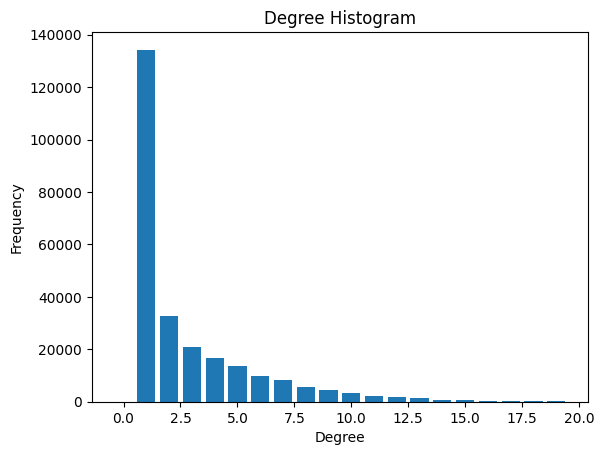

In [18]:
plt.bar(list(x for x in range(len(deg_hist[:20]))), deg_hist[:20], align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Esetleg latvanyosabb ha azt mondjuk hogy kizárjuk az 1 fokszámot, merthogy az csak 1 ember javaslata/ 1 db javaslat (A többi 25 - nél nagyobb fokszám pedig nagyjából mind 0,1,2,3 gyakoriságú)

^- Ez nem igazán így van. A degree-k itt azt jelentik, hogy egy adott MEP hány emberrel kollaborált.

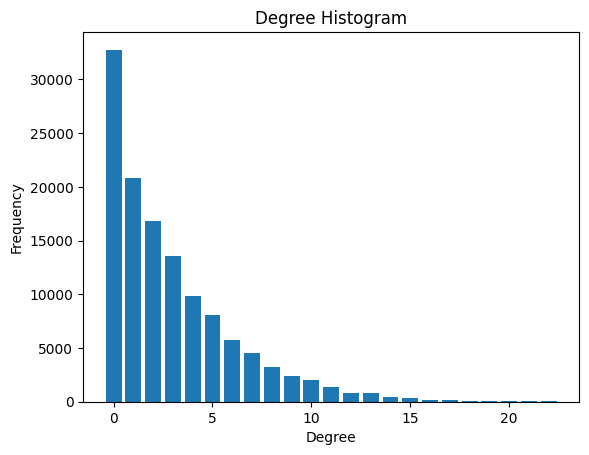

In [19]:
plt.bar(list(x for x in range(len(deg_hist[2:25]))), deg_hist[2:25], align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [20]:
### melyik ország politikusai csináltak többet?

contribs_by_country = {}

for node in mep_social_network:
    curr_country = getMEPData("MEPName", node)["MemberState"]
    if curr_country not in contribs_by_country:
        contribs_by_country[curr_country] = 0
    contribs_by_country[curr_country] += mep_social_network.degree(node)

print(contribs_by_country)

{'Czechia': 1020, 'Poland': 2531, 'France': 4243, 'Netherlands': 1941, 'Slovakia': 1201, 'Romania': 2497, 'Spain': 3853, 'Croatia': 636, 'Greece': 1092, 'Portugal': 1406, 'Italy': 3550, 'United Kingdom': 268, 'Belgium': 1411, 'Germany': 5539, 'Finland': 859, 'Bulgaria': 1260, 'Ireland': 806, 'Hungary': 1135, 'Sweden': 1613, 'Malta': 614, 'Austria': 1272, 'Slovenia': 760, 'Latvia': 426, 'Cyprus': 502, 'Luxembourg': 623, 'Lithuania': 541, 'Estonia': 423, 'Denmark': 955, '': 175}


Az üres string ország politikusai nem tudom mit reprezentálnak.

TODO: ebből ábrát kéne csinálni, szépet, ami mutatja hogy melyik ország politikusai mennyit adnak hozzá a bulihoz

In [21]:
del contribs_by_country[""] # kidobom az üres stringet mert bruh

In [22]:
## ugyanez csak normáljuk az adatsort az országok populációjával
contribs_by_country_per_million = { country : val*(10**6)/(getPopulationData(country)) for country, val in contribs_by_country.items()}
print(contribs_by_country_per_million)

{'Czechia': 96.91978472025387, 'Poland': 66.54201672210608, 'France': 65.00773703915328, 'Netherlands': 110.34257247250133, 'Slovakia': 221.22785326827773, 'Romania': 131.04987111504965, 'Spain': 81.28555135295402, 'Croatia': 164.26328304965634, 'Greece': 104.67308783021028, 'Portugal': 135.93648150364697, 'Italy': 60.322119779781104, 'United Kingdom': 4.001194386383995, 'Belgium': 121.80585510645365, 'Germany': 66.54482680107976, 'Finland': 154.38616671189817, 'Bulgaria': 193.25778794375094, 'Ireland': 156.53102392458234, 'Hungary': 116.1391934885103, 'Sweden': 153.30432114793666, 'Malta': 1181.764640216182, 'Austria': 139.68618488257246, 'Slovenia': 360.6716085004603, 'Latvia': 225.01311255990447, 'Cyprus': 546.7813963620521, 'Luxembourg': 965.2973286209883, 'Lithuania': 192.47456471752668, 'Estonia': 317.6095339924795, 'Denmark': 160.97348673966155}


In [23]:
### melyik évben mennyit dolgoztak?
### ez jelen pillanatban nem működik :(

contribs_by_year = {}

for node in myGraph.nodes():
    if type(node) == int: # ez egy nagyon maszek módja hogy csak az amendmenteket nézzük
        if node[1].year not in contribs_by_year:
            contribs_by_year[node[1].year] = 0
    print(node)
        #contribs_by_year[node[1].year] += myGraph.degree(node)
    #    contribs_by_year[node[1].year] += 1
        
#contribs_by_year

TypeError: 'int' object is not subscriptable

Nem igazán látszik se a COVID se az ukrajnai háború hatása a kontribúciók számában.

## MEP_SOCIAL_NETWORK

In [24]:
mep_social_network

In [25]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(mep_social_network)}\n"
        f"Number of edges: {nx.number_of_edges(mep_social_network)}\n")

Some information about this graph:
Number of nodes: 754
Number of edges: 21576



### By years 2020 and 2021

Let us create 2 social network graphs corresponding to the years 2020 and 2021

In [26]:
df = pd.read_csv('db/ep_cosponsorship_dataset.csv', header = 0, keep_default_na = False)
df2020 = df[df['Date'].str.contains("2020") == True]
df2021 = df[df['Date'].str.contains("2021") == True]

list_meps_2020 = pd.unique(df2020["OfficialMEPID"])
list_meps_2021 = pd.unique(df2021["OfficialMEPID"])


In [27]:
myGraph2020 = nx.from_pandas_edgelist(df2020, source='AmendmentID', target='OfficialMEPID')
myGraph2021 = nx.from_pandas_edgelist(df2021, source='AmendmentID', target='OfficialMEPID')


print(f'The 2020 Graph is bipartite: {nx.is_bipartite(myGraph2020)}')
print(f'The 2021 Graph is bipartite: {nx.is_bipartite(myGraph2021)}')


The 2020 Graph is bipartite: True
The 2021 Graph is bipartite: True


In [28]:
mep_social_network_2020 = nx.algorithms.bipartite.projected_graph(myGraph2020, list_meps_2020)
mep_social_network_2021 = nx.algorithms.bipartite.projected_graph(myGraph2021, list_meps_2021)

Consider some famous and important centrality measures: Degree centrality, betweenness centrality, eigenvector centrality 

For 2020:

In [29]:
Deg_Cent_2020_UnSort = nx.degree_centrality(mep_social_network_2020)
Eig_Cent_2020_UnSort = nx.eigenvector_centrality(mep_social_network_2020, max_iter=1000, tol=1e-06, nstart=None, weight=None)
Btw_Cent_2020_UnSort = nx.betweenness_centrality(mep_social_network_2020, k=None, normalized=True, weight=None, endpoints=False, seed=None)

Sorting them by value

In [30]:
Deg_Cent_2020 = sorted(Deg_Cent_2020_UnSort.items(), key=lambda x:x[1], reverse=True)
Eig_Cent_2020 = sorted(Eig_Cent_2020_UnSort.items(), key=lambda x:x[1], reverse=True)
Btw_Cent_2020 = sorted(Btw_Cent_2020_UnSort.items(), key=lambda x:x[1], reverse=True)


For 2021:

In [31]:
Deg_Cent_2021_UnSort = nx.degree_centrality(mep_social_network_2021)
Eig_Cent_2021_UnSort = nx.eigenvector_centrality(mep_social_network_2021, max_iter=1000, tol=1e-06, nstart=None, weight=None)
Btw_Cent_2021_UnSort = nx.betweenness_centrality(mep_social_network_2021, k=None, normalized=True, weight=None, endpoints=False, seed=None)

Sorting them by value

In [32]:
Deg_Cent_2021 = sorted(Deg_Cent_2021_UnSort.items(), key=lambda x:x[1], reverse=True)
Eig_Cent_2021 = sorted(Eig_Cent_2021_UnSort.items(), key=lambda x:x[1], reverse=True)
Btw_Cent_2021 = sorted(Btw_Cent_2021_UnSort.items(), key=lambda x:x[1], reverse=True)

Let us look at betweenness centrality first

In [33]:
x = [Btw_Cent_2020[i][0] for i in range(len(Btw_Cent_2020[:10]))] # top 10 MEP according to betweenness centrality in 2020
y1 = [Btw_Cent_2020_UnSort[x[i]] for i in range(len(x)) ]         #betweenness centrality values top 10 MEP in 2020
y2=[]                                                             #betweenness centrality values top 10 MEP in 2021
for i in range(len(x)):
    try: 
        y2.append(Btw_Cent_2021_UnSort[x[i]])
    except: 
        y2.append(0)
          

print(Btw_Cent_2021[:10])
print(x)
print(y1)
print(y2)

[('197614', 0.03838145248439457), ('96867', 0.034510072729735185), ('197523', 0.03425607711855597), ('197790', 0.03235720122000254), ('', 0.02974096548954125), ('198490', 0.02655334393897524), ('123562', 0.021131013290033966), ('124766', 0.0198647770416676), ('192635', 0.01890592245214629), ('197670', 0.017531289428355246)]
['197806', '124785', '124812', '', '28266', '197493', '124738', '197532', '132191', '96903']
[0.027222288814423165, 0.024537698080261718, 0.024215151613408495, 0.02337123997200883, 0.022662956720020857, 0.022000470850908962, 0.021599358034329476, 0.01771816852255001, 0.01634070250587688, 0.015133587585353114]
[0.0041774485721426564, 0.006768634422964896, 0.008666286663841402, 0.02974096548954125, 0.0013860384123385605, 0.0009615391997285037, 0.005511462676472655, 0.0007849790587171986, 0.0031378363519803253, 0.005653924643841413]


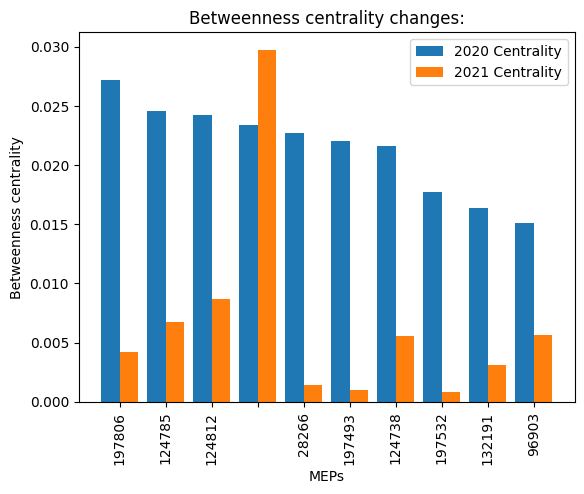

In [34]:
X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y1, 0.4, label = '2020 Centrality')
plt.bar(X_axis + 0.2, y2, 0.4, label = '2021 Centrality')
  
plt.xticks(X_axis, x, rotation = 90)
plt.xlabel("MEPs")
plt.ylabel("Betweenness centrality")
plt.title("Betweenness centrality changes:")
plt.legend()
plt.show()

Basically the above graph represents the betweenness centrality changes for the top 10 EMPs (according to measurements from 2020)

Let us also look at Eigenvector Centrality but now let us observe the centrality measures in 2020, for the top 10 most influential MEPs (according to 2021 measurements). That is who the benificiaries of the changes were from 2020 to 2021.

In [35]:
x = [Eig_Cent_2021[i][0] for i in range(len(Eig_Cent_2021[:10]))] # top 10 MEP according to eigenvector centrality in 2021
y2 = [Eig_Cent_2021_UnSort[x[i]] for i in range(len(x)) ]         #eigenvector centrality values top 10 MEP in 2021
y1=[]                                                             #eigenvector centrality values top 10 MEP in 2020
for i in range(len(x)):
    try: 
        y1.append(Eig_Cent_2020_UnSort[x[i]])
    except: 
        y1.append(0)
          

print(Eig_Cent_2021[:10])
print(x)
print(y1)
print(y2)

[('130100', 0.14858573701749217), ('197567', 0.1392665190249663), ('197463', 0.13083224892664938), ('202073', 0.13044955737238353), ('197523', 0.1296341678266221), ('103746', 0.12412865421228003), ('197869', 0.12349891163756983), ('134605', 0.1196878023456399), ('', 0.10857996764910478), ('209091', 0.10802263633633685)]
['130100', '197567', '197463', '202073', '197523', '103746', '197869', '134605', '', '209091']
[0.12842530091982832, 0.09931017676123369, 0.10006083952973675, 0.09293407125797892, 0.0729441666992619, 0.08813788434324722, 0.08174617803466834, 0.08166004537342293, 0.0833743509462057, 0]
[0.14858573701749217, 0.1392665190249663, 0.13083224892664938, 0.13044955737238353, 0.1296341678266221, 0.12412865421228003, 0.12349891163756983, 0.1196878023456399, 0.10857996764910478, 0.10802263633633685]


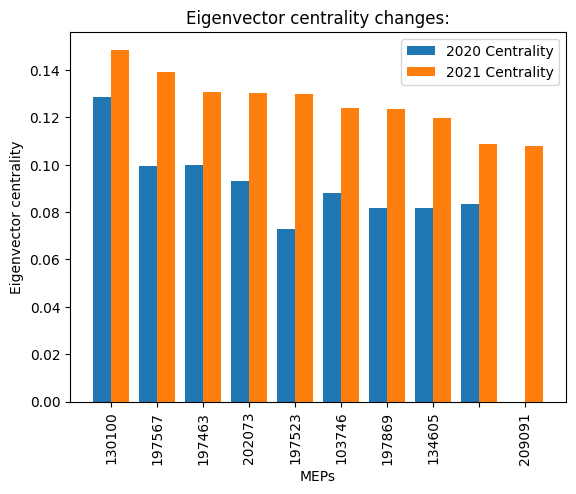

In [36]:
X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y1, 0.4, label = '2020 Centrality')
plt.bar(X_axis + 0.2, y2, 0.4, label = '2021 Centrality')
  
plt.xticks(X_axis, x, rotation = 90)
plt.xlabel("MEPs")
plt.ylabel("Eigenvector centrality")
plt.title("Eigenvector centrality changes:")
plt.legend()
plt.show()

# SPLITTING THE DATA

In [37]:
import datetime
time_intervals = [
    {
        "start" : pd.to_datetime(datetime.date(2019,7,24)),
        "end" : pd.to_datetime(datetime.date(2019,10,31))
    }, #0
    {
        "start" : pd.to_datetime(datetime.date(2019,11,1)),
        "end" : pd.to_datetime(datetime.date(2020,1,31))
    }, #1
    {
        "start" : pd.to_datetime(datetime.date(2020,2,1)),
        "end" : pd.to_datetime(datetime.date(2020,5,20))
    }, #2
    {
        "start" : pd.to_datetime(datetime.date(2020,5,21)),
        "end" : pd.to_datetime(datetime.date(2020,8,31))
    }, #3
    {
        "start" : pd.to_datetime(datetime.date(2020,9,1)),
        "end" : pd.to_datetime(datetime.date(2020,11,30))
    }, #4
    {
        "start" : pd.to_datetime(datetime.date(2020,12,1)),
        "end" : pd.to_datetime(datetime.date(2021,3,3))
    }, #5
    {
        "start" : pd.to_datetime(datetime.date(2021,3,4)),
        "end" : pd.to_datetime(datetime.date(2021,5,31))
    }, #6
    {
        "start" : pd.to_datetime(datetime.date(2021,6,1)),
        "end" : pd.to_datetime(datetime.date(2021,8,31))
    }, #7
    {
        "start" : pd.to_datetime(datetime.date(2021,9,1)),
        "end" : pd.to_datetime(datetime.date(2021,11,30))
    }, #8
    {
        "start" : pd.to_datetime(datetime.date(2021,12,1)),
        "end" : pd.to_datetime(datetime.date(2022,2,23))
    }, #9
    {
        "start" : pd.to_datetime(datetime.date(2022,2,24)),
        "end" : pd.to_datetime(datetime.date(2022,5,31))
    }, #10
    {
        "start" : pd.to_datetime(datetime.date(2022,6,1)),
        "end" : pd.to_datetime(datetime.date(2022,9,5))
    } #11
]

for i in time_intervals:
    i["length"] = i["end"] - i["start"]
    
print(time_intervals)

[{'start': Timestamp('2019-07-24 00:00:00'), 'end': Timestamp('2019-10-31 00:00:00'), 'length': Timedelta('99 days 00:00:00')}, {'start': Timestamp('2019-11-01 00:00:00'), 'end': Timestamp('2020-01-31 00:00:00'), 'length': Timedelta('91 days 00:00:00')}, {'start': Timestamp('2020-02-01 00:00:00'), 'end': Timestamp('2020-05-20 00:00:00'), 'length': Timedelta('109 days 00:00:00')}, {'start': Timestamp('2020-05-21 00:00:00'), 'end': Timestamp('2020-08-31 00:00:00'), 'length': Timedelta('102 days 00:00:00')}, {'start': Timestamp('2020-09-01 00:00:00'), 'end': Timestamp('2020-11-30 00:00:00'), 'length': Timedelta('90 days 00:00:00')}, {'start': Timestamp('2020-12-01 00:00:00'), 'end': Timestamp('2021-03-03 00:00:00'), 'length': Timedelta('92 days 00:00:00')}, {'start': Timestamp('2021-03-04 00:00:00'), 'end': Timestamp('2021-05-31 00:00:00'), 'length': Timedelta('88 days 00:00:00')}, {'start': Timestamp('2021-06-01 00:00:00'), 'end': Timestamp('2021-08-31 00:00:00'), 'length': Timedelta('91

In [38]:
ENTIRE_DATASET["Date"] = pd.to_datetime(ENTIRE_DATASET["Date"], format = "%d/%m/%Y")

In [39]:
split_data = []

for i in time_intervals:
    split_data.append(ENTIRE_DATASET[( ENTIRE_DATASET["Date"] >= i["start"])
                                     & ( ENTIRE_DATASET["Date"] <= pd.to_datetime(i["end"]))])

print(split_data)

[      AmendmentID Committee          Dossier       Date         PENumber  \
0          892323      ENVI  2019/2028 (BUD) 2019-07-24  PE639.804v01-00   
1          880086      ENVI  2019/2028 (BUD) 2019-07-24  PE639.804v01-00   
2          885326      ENVI  2019/2028 (BUD) 2019-07-24  PE639.804v01-00   
3          891589      ENVI  2019/2028 (BUD) 2019-07-24  PE639.804v01-00   
4          881777      ENVI  2019/2028 (BUD) 2019-07-24  PE639.804v01-00   
...           ...       ...              ...        ...              ...   
6286       893462      AFET  2019/2125 (INI) 2019-10-28  PE642.989v01-00   
6287       885945      AFET  2019/2125 (INI) 2019-10-28  PE642.989v01-00   
6288       885945      AFET  2019/2125 (INI) 2019-10-28  PE642.989v01-00   
6289       885945      AFET  2019/2125 (INI) 2019-10-28  PE642.989v01-00   
6290       892316      AFET  2019/2125 (INI) 2019-10-28  PE642.989v01-00   

      DocumentType OfficialMEPID              MEPName  MemberState  \
0     DraftOpini

In [40]:
s = 0
for i in split_data:
    x = len(i)
    print(x)
    s += x
print(f"SUM = {s}")

6291
18590
52589
71793
85737
70345
64459
75077
51429
105180
86629
62853
SUM = 750972


^- Ennyi adatpontunk van intervallumonként. Nekem balanceoltnak tűnik őszintén szólva.

In [41]:
def listMEPs_div(GDataset): # listing the different MEP names for the given dataset
    o = pd.unique(GDataset['MEPName'])
    #print(type(o)) #DEBUG
    return o

ListsMEP = [listMEPs_div(miniGraph) for miniGraph in split_data]#list for each subgraph
            
#defining 2 function for the projection creation
def CreateNXGraph(Graph):
    # we use MEPName instead of OfficialMEPID
    G = nx.from_pandas_edgelist(Graph, source='AmendmentID', target='MEPName')
    return G

def CreateBipartite(myGraph, Gtype, MEP_lista):
    #Gtype = which type of projection we use 
    if Gtype == "classic":
        G = nx.algorithms.bipartite.projected_graph(myGraph, MEP_lista)
    elif Gtype == "collab_weight":
        G = nx.algorithms.bipartite.collaboration_weighted_projected_graph(myGraph, MEP_lista)
    return G 


In [42]:
All_projections_classic = [CreateBipartite(CreateNXGraph(split_data[i]), "classic", ListsMEP[i]) for i in range(len(split_data))]
All_projections_weighted = [CreateBipartite(CreateNXGraph(split_data[i]), "collab_weight", ListsMEP[i]) for i in range(len(split_data))]

The list above (All_projection) contains the 12 different projections of the 12 different subgraphs we created. The two different lists correspond the 2 different ways of projections we created

[]

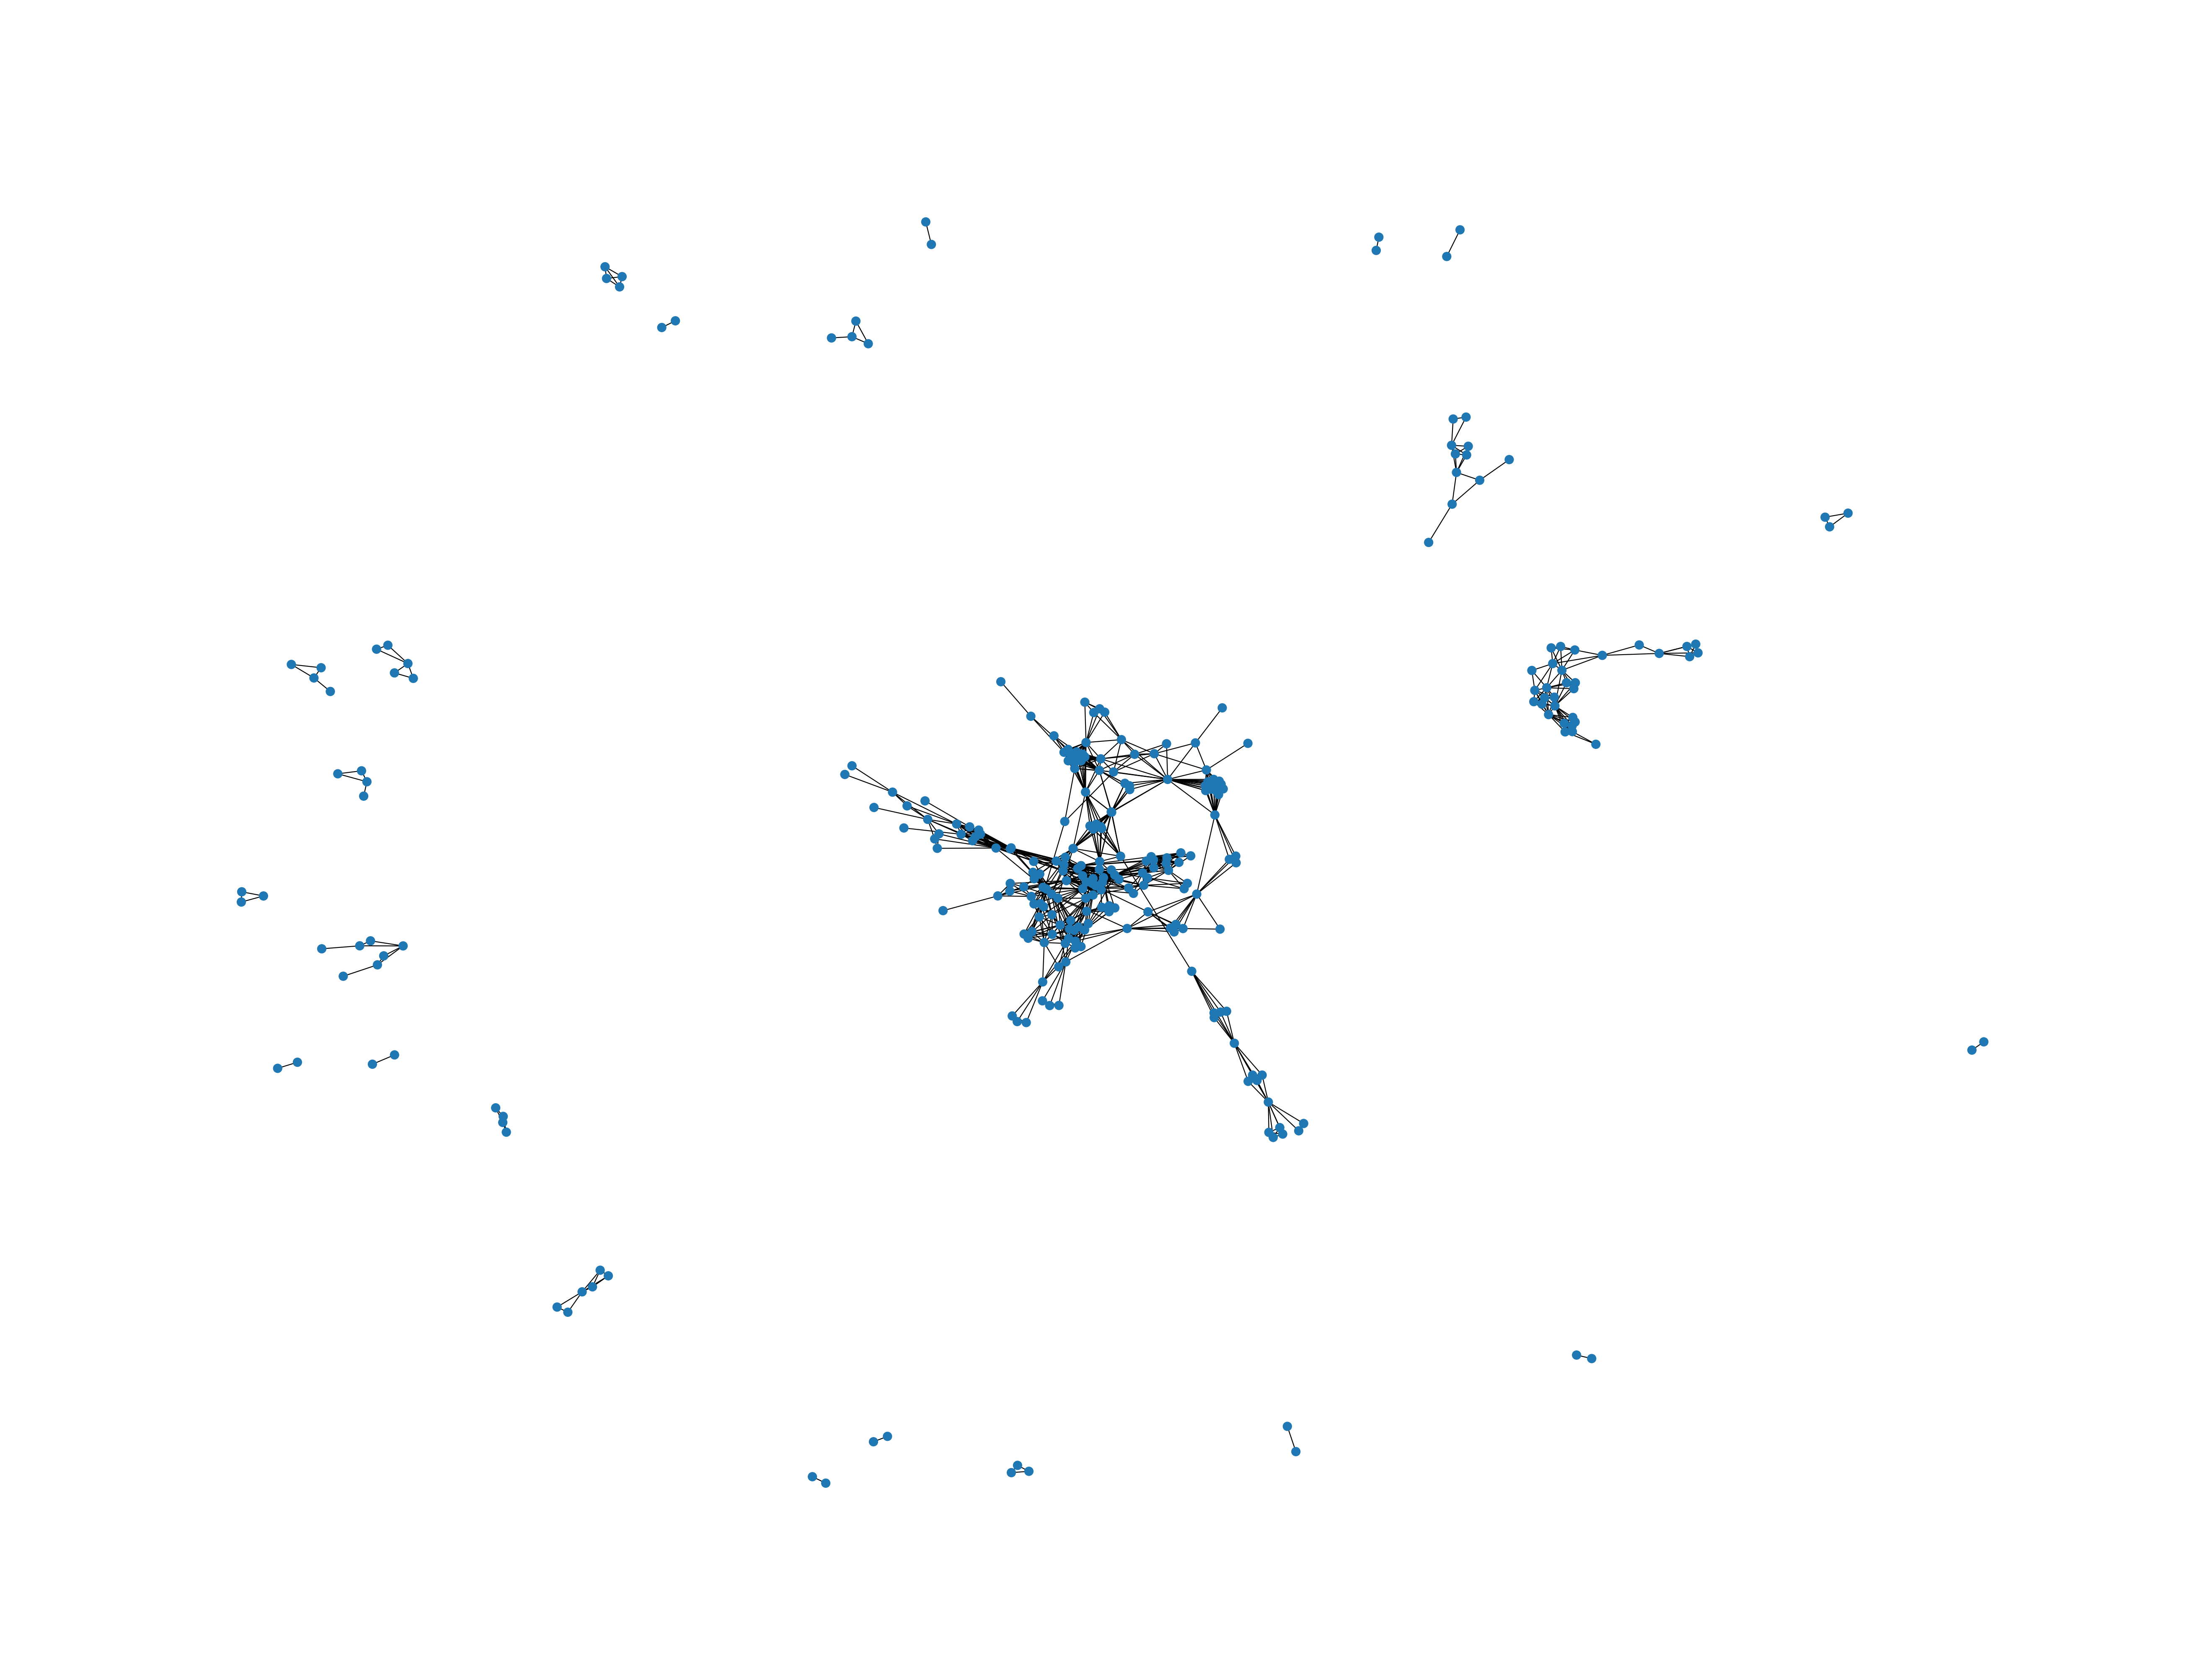

In [43]:
# G_0 = All_projections_classic[0]
# Gcc = sorted(nx.connected_components(G_0), key=len, reverse=True)
# G_1 = G_0.subgraph(Gcc[0])
# This code would give us the biggest component in a graph

G_1 = All_projections_classic[0]

plt.figure(dpi = 800) #dpi = 500 ? 
pos = nx.random_layout(G_1, seed=696)
d = dict(G_1.degree)
nx.draw(G_1, nodelist=d.keys(), node_size=[1 * int(v != 0)  for v in d.values()], width = 0.2)
plt.plot()

In [44]:
#The different EU parties: 
#EPP        -  European Peoples Party
#S&D        -  Party of European Socialists
#RE         -  Alliance of Liberals and Democrats for Europe Party  /  European Democratic Party
#ECR        -  European Conservatives and Reformists Party
#ID         -  Identity and Democracy Party
#Greens/EFA -  European Green Party/European Free Alliance
#GUE/NGL    -  Party of the European Left


#(EPP  és ECR -	European Christian Political Movement)

Hierarchic Cluster for the original graph and the colorful graph colored according to the EP groups

In [48]:

def Clustering(Graf,N_of_clusters):
    return 0

def coloring_list(Graf):
    color_map = []
    for node in Graf:
        print(getMEPData(0,node)['EPGroup'])
        if getMEPData(0,node)['EPGroup'] == 'EPP':
            color_map.append('blue')
        elif getMEPData(0,node)['EPGroup'] == 'S&D':
            color_map.append('red')
        elif getMEPData(0,node)['EPGroup'] == 'RE':
            color_map.append('yellow')
        elif getMEPData(0,node)['EPGroup'] == 'ECR':
            color_map.append('orange')  
        elif getMEPData(0,node)['EPGroup'] == 'ID':
            color_map.append('white')   
        elif getMEPData(0,node)['EPGroup'] == 'Greens/EFA':
            color_map.append('green')
        else:
            color_map.append('white')

    print(f"Length of the color mapping:{len(color_map)}")
    print(f"Length of the node list:{len(Graf.nodes())}")
    return color_map
    
    



def Color_EPgroups_in_graph(Graf,color_map):

    plt.figure(dpi = 800)
    d = dict(G_1.degree)
    nx.draw(G_1, node_size=0.3, width = 0.1, node_color=color_map, with_labels=False) #node_size=[0.3 * int(v != 0)  for v in d.values()]
    plt.plot()
    return 0


In [46]:
ENTIRE_DATASET
ALL_MEP_lista = listMEPs_div(ENTIRE_DATASET) 
The_Weighted_Graf = CreateBipartite(CreateNXGraph(ENTIRE_DATASET), "collab_weight", ALL_MEP_lista) 
CM = coloring_list(The_Weighted_Graf)

EPP
ECR
ID
Greens/EFA
RE
S&D
RE
EPP
S&D
S&D
S&D
S&D
NI
ECR
EPP
RE
EPP
ECR
S&D
S&D
EPP
ECR
ECR
ECR
ECR
EPP
RE
RE
Greens/EFA
ID
RE
ID
ID
ID
NI
ID
ID
ID
ID
RE
RE
RE
Greens/EFA
RE
RE
S&D
ID
ID
ID
ID
ID
EPP
EPP
EPP
EPP
EPP
EPP
EPP
EPP
EPP
EPP
EPP
ECR
S&D
S&D
ECR
ECR
S&D
S&D
EPP
GUE/NGL
GUE/NGL
GUE/NGL
EPP
GUE/NGL
ID
GUE/NGL
ID
ID
ID
S&D
S&D
Greens/EFA
RE
RE
RE
RE
RE
RE
EPP
RE
Greens/EFA
NI
ID
ECR
ECR
EPP
ID
RE
RE
S&D
S&D
EPP
EPP
S&D
NI
ECR
S&D
RE
RE
RE
RE
RE
RE
RE
GUE/NGL
GUE/NGL
ECR
RE
RE
NI
RE
S&D
ECR
ECR
S&D
EPP
EPP
EPP
EPP
EPP
EPP
S&D
S&D
RE
S&D
ECR
S&D
Greens/EFA
GUE/NGL
RE
RE
RE
RE
RE
RE
RE
RE
GUE/NGL
GUE/NGL
GUE/NGL
GUE/NGL
GUE/NGL
EPP
ECR
EPP
EPP
ECR
ECR
ECR
ECR
ID
Greens/EFA
S&D
S&D
S&D
S&D
S&D
S&D
S&D
S&D
RE
RE
RE
RE
RE
EPP
EPP
GUE/NGL
EPP
EPP
EPP
EPP
RE
RE
ECR
S&D
S&D
S&D
RE
RE
RE
S&D
S&D
ECR
S&D
Greens/EFA
EPP
RE
S&D
Greens/EFA
S&D
ECR
Greens/EFA
EPP
S&D
GUE/NGL
EPP
S&D
EPP
EPP
RE
RE
RE
RE
GUE/NGL
ID
ECR
S&D
EPP
NI
ID
ID
ID
ID
EPP
RE
RE
RE
RE
RE
GUE/NGL
EPP
S&D
ID
EPP
S&D
ID
ID


In [49]:
CM = Color_EPgroups_in_graph(The_Weighted_Graf, CM)
    

ValueError: 'c' argument has 754 elements, which is inconsistent with 'x' and 'y' with size 405.

: 

: 

In [ ]:
NNodes = ["anna", "balazs", "cecil", "draven", "emil", "frufru", "gabi", "hajnal" ]
EEdges = [("anna", "balazs"),("balazs", "cecil"), ("cecil", "draven"), ("draven", "anna"), ("emil", "frufru"), ("frufru", "gabi"), ("gabi", "hajnal"), ("hajnal", "emil"), ("anna", "emil"), ("balazs", "frufru"), ("cecil", "gabi"), ("draven","hajnal" )]
G = nx.Graph(nodes = NNodes, edges = EEdges)

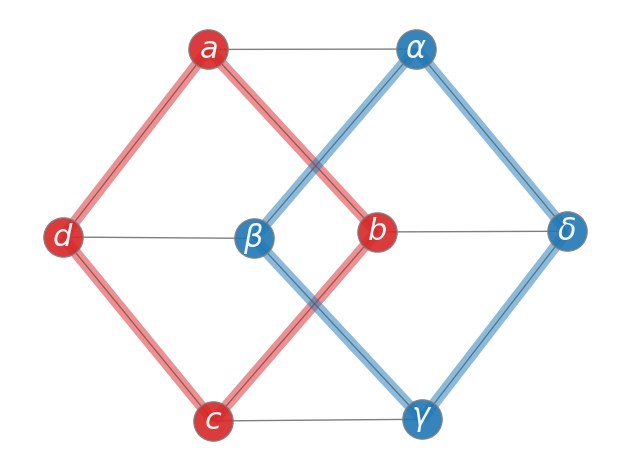

In [ ]:
G = nx.cubical_graph()
pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes

# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=[0, 1, 2, 3], node_color="tab:red", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[4, 5, 6, 7], node_color="tab:blue", **options)

# edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[(0, 1), (1, 2), (2, 3), (3, 0)],
    width=8,
    alpha=0.5,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[(4, 5), (5, 6), (6, 7), (7, 4)],
    width=8,
    alpha=0.5,
    edge_color="tab:blue",
)


# some math labels
labels = {}
labels[0] = r"$a$"
labels[1] = r"$b$"
labels[2] = r"$c$"
labels[3] = r"$d$"
labels[4] = r"$\alpha$"
labels[5] = r"$\beta$"
labels[6] = r"$\gamma$"
labels[7] = r"$\delta$"
nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="whitesmoke")

plt.tight_layout()
plt.axis("off")
plt.show()